## 0. Importing PyTorch and setting up device-agnostic code

In [ ]:
import torch
from torch import nn

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:",{device})
print()

if device.type =="cuda":
  print(torch.cuda.get_device_name(0))

Using device: {device(type='cuda')}

Tesla T4


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Training on GPU...Ready for HyperJumo...")
else:
    device = torch.device("cpu")
    print("Training on CPU...May the force be with you...")


Training on GPU...Ready for HyperJumo...


## 1. Get Data



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
from pathlib import Path

zip_path="/content/drive/MyDrive/Colab Notebooks/supervised.zip"
image_path = Path("/content/data")

with zipfile.ZipFile(zip_path ,"r") as zip_ref:
    zip_ref.extractall(image_path)

print(f"The zip file is extracted to the '{image_path}' directory.")


The zip file is extracted to the '/content/data' directory.


In [ ]:
import os

total_files = 0
for root, dirs, files in os.walk(image_path):
    total_files+= len(files)

print(f"Total number of files found: {total_files}")

Total number of files found: 10001


In [ ]:
for dirpath, dirnames, filenames in os.walk(image_path):
    print(f" There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

 There are 1 directories and 0 images in '/content/data'
 There are 1 directories and 1 images in '/content/data/supervised'
 There are 2 directories and 0 images in '/content/data/supervised/dataset'
 There are 30 directories and 0 images in '/content/data/supervised/dataset/train'
 There are 0 directories and 234 images in '/content/data/supervised/dataset/train/RailwayStation'
 There are 0 directories and 378 images in '/content/data/supervised/dataset/train/Viaduct'
 There are 0 directories and 333 images in '/content/data/supervised/dataset/train/Farmland'
 There are 0 directories and 378 images in '/content/data/supervised/dataset/train/Pond'
 There are 0 directories and 369 images in '/content/data/supervised/dataset/train/River'
 There are 0 directories and 306 images in '/content/data/supervised/dataset/train/Mountain'
 There are 0 directories and 351 images in '/content/data/supervised/dataset/train/Parking'
 There are 0 directories and 315 images in '/content/data/supervised

In [ ]:
train_dir = image_path / "supervised/dataset/train"
test_dir = image_path / "supervised/dataset/test"

train_dir ,test_dir

(PosixPath('/content/data/supervised/dataset/train'),
 PosixPath('/content/data/supervised/dataset/test'))

/content/data/supervised/dataset/train/Mountain/mountain_220.jpg
Mountain
Random image path: /content/data/supervised/dataset/train/Mountain/mountain_220.jpg
Image class: Mountain
Image height: 600
Image width: 600


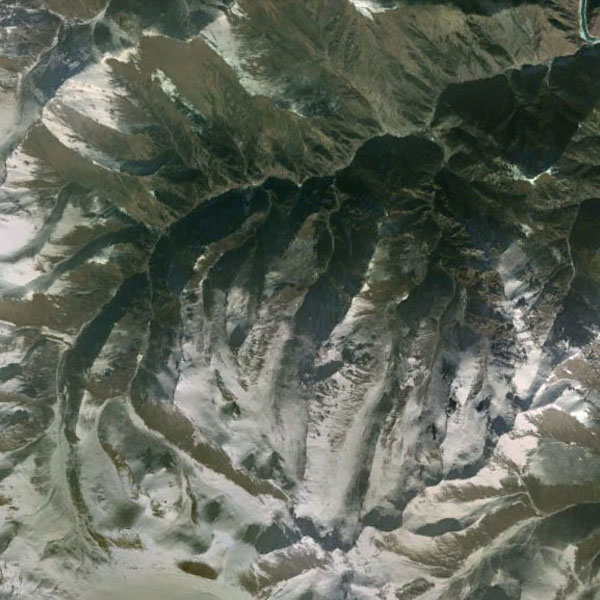

In [ ]:
import random
from PIL import Image

random.seed(42)
image_path_list = list(image_path.glob("*/*/*/*/*.jpg"))
random_image_path = random.choice(image_path_list)
print(random_image_path)

image_class = random_image_path.parent.stem
print(image_class)

img= Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

## 3. Transforming data

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from torchvision import transforms

data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# if isinstance(img, Image.Image) or isinstance(img, np.ndarray):
#     img_tensor = transforms.ToTensor()(img)
# else:
#     img_tensor = img

# Convert PIL Image to PyTorch tensor
img_tensor = transforms.ToTensor()(img)

# Now you can check the min and max values
print(img_tensor.min(), img_tensor.max())



tensor(0.0078) tensor(1.)


In [ ]:
data_transform(img)

tensor([[[-1.7069, -1.6555, -1.6213,  ..., -0.6794, -0.5938, -0.4911],
         [-1.6727, -1.6727, -1.5870,  ..., -0.6965, -0.6452, -0.6281],
         [-1.6213, -1.6384, -1.6213,  ..., -0.6965, -0.6965, -0.7137],
         ...,
         [-0.0629,  0.1083,  0.2796,  ...,  0.6906,  0.6563,  0.6563],
         [ 0.5878,  0.9303,  0.9132,  ...,  0.6563,  0.6392,  0.6734],
         [ 0.8276,  1.3070,  1.3413,  ...,  0.6049,  0.6734,  0.7077]],

        [[-1.4230, -1.3529, -1.3354,  ..., -0.5126, -0.4251, -0.3375],
         [-1.3704, -1.3704, -1.3004,  ..., -0.5476, -0.4951, -0.4776],
         [-1.3354, -1.3529, -1.3354,  ..., -0.5476, -0.5301, -0.5476],
         ...,
         [ 0.0476,  0.2052,  0.3803,  ...,  0.8880,  0.8880,  0.8704],
         [ 0.7129,  1.0630,  1.0105,  ...,  0.8880,  0.8880,  0.9405],
         [ 0.9405,  1.4482,  1.4482,  ...,  0.8529,  0.9055,  0.9580]],

        [[-1.3861, -1.2990, -1.2293,  ..., -0.6367, -0.5495, -0.4624],
         [-1.3339, -1.3164, -1.2293,  ..., -0

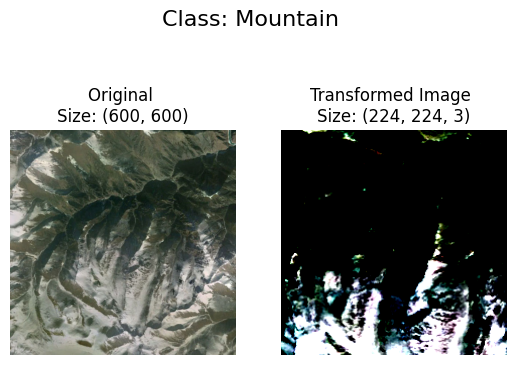

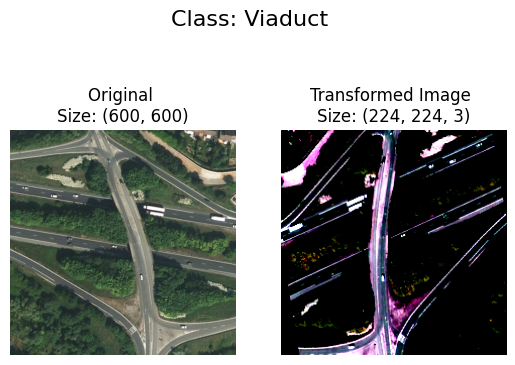

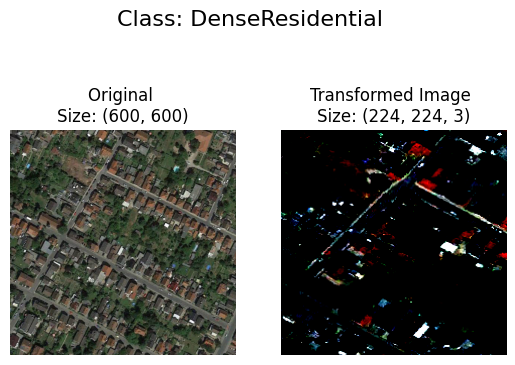

In [ ]:
import torchvision
# Plots a series of random images from image_paths
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)

    for image_path in random_image_paths:
        with Image.open(image_path) as f:
          fig ,ax  = plt.subplots(1,2)
          ax[0].imshow(f)
          ax[0].set_title(f"Original \nSize: {f.size}")
          ax[0].axis("off")
          transformed_image = transform(f).permute(1,2,0).numpy()
          ax[1].imshow(transformed_image)
          ax[1].set_title(f"Transformed Image \nSize: {transformed_image.shape}")
          ax[1].axis("off")

          fig.suptitle(f"Class: {image_path.parent.stem}" ,fontsize=16)

plot_transformed_images(image_path_list, transform=data_transform, n=3)

In [ ]:
train_data = datasets.ImageFolder(root="/content/data/supervised/dataset/train" , transform=data_transform, target_transform=None)
test_data = datasets.ImageFolder(root="/content/data/supervised/dataset/test" ,transform=data_transform)

train_data ,test_data

(Dataset ImageFolder
     Number of datapoints: 9000
     Root location: /content/data/supervised/dataset/train
     StandardTransform
 Transform: Compose(
                RandomHorizontalFlip(p=0.5)
                RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
                ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2))
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset ImageFolder
     Number of datapoints: 1000
     Root location: /content/data/supervised/dataset/test
     StandardTransform
 Transform: Compose(
                RandomHorizontalFlip(p=0.5)
                RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
                ColorJitter(brightne

In [ ]:
class_names = train_data.classes
class_dict = train_data.class_to_idx
class_names,class_dict

(['Airport',
  'BareLand',
  'BaseballField',
  'Beach',
  'Bridge',
  'Center',
  'Church',
  'Commercial',
  'DenseResidential',
  'Desert',
  'Farmland',
  'Forest',
  'Industrial',
  'Meadow',
  'MediumResidential',
  'Mountain',
  'Park',
  'Parking',
  'Playground',
  'Pond',
  'Port',
  'RailwayStation',
  'Resort',
  'River',
  'School',
  'SparseResidential',
  'Square',
  'Stadium',
  'StorageTanks',
  'Viaduct'],
 {'Airport': 0,
  'BareLand': 1,
  'BaseballField': 2,
  'Beach': 3,
  'Bridge': 4,
  'Center': 5,
  'Church': 6,
  'Commercial': 7,
  'DenseResidential': 8,
  'Desert': 9,
  'Farmland': 10,
  'Forest': 11,
  'Industrial': 12,
  'Meadow': 13,
  'MediumResidential': 14,
  'Mountain': 15,
  'Park': 16,
  'Parking': 17,
  'Playground': 18,
  'Pond': 19,
  'Port': 20,
  'RailwayStation': 21,
  'Resort': 22,
  'River': 23,
  'School': 24,
  'SparseResidential': 25,
  'Square': 26,
  'Stadium': 27,
  'StorageTanks': 28,
  'Viaduct': 29})

In [ ]:
len(train_data), len(test_data)

(9000, 1000)

In [ ]:
train_data.samples[0]

('/content/data/supervised/dataset/train/Airport/airport_1.jpg', 0)

In [ ]:
img ,label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[1.0331, 1.0159, 0.9988,  ..., 1.8550, 1.8722, 1.8037],
         [1.2899, 1.3413, 1.3927,  ..., 1.8550, 1.8037, 1.8208],
         [1.5982, 1.6495, 1.6838,  ..., 1.9064, 1.7694, 1.6667],
         ...,
         [1.4098, 1.4269, 1.3584,  ..., 1.2899, 1.3070, 1.3413],
         [1.3070, 1.3242, 1.2728,  ..., 1.2728, 1.2899, 1.2899],
         [1.0844, 1.0844, 1.0159,  ..., 1.2043, 1.1700, 1.1700]],

        [[1.0805, 1.0805, 1.0455,  ..., 1.8508, 1.9559, 1.9034],
         [1.2556, 1.2906, 1.3256,  ..., 1.8683, 1.8508, 1.9034],
         [1.5182, 1.5532, 1.5532,  ..., 1.9559, 1.7983, 1.6758],
         ...,
         [1.5007, 1.5007, 1.4307,  ..., 1.1331, 1.1856, 1.1856],
         [1.3606, 1.3606, 1.3606,  ..., 1.0630, 1.1155, 1.1155],
         [1.1331, 1.1155, 1.0980,  ..., 0.9930, 0.9755, 0.9755]],

        [[1.3328, 1.3328, 1.2980,  ..., 1.9951, 2.1171, 2.0823],
         [1.3154, 1.3328, 1.2980,  ..., 1.9951, 2.0125, 2.0474],
         [1.4025, 1.3851, 1.3502,  ..., 1.97

Original shape: torch.Size([3, 224, 224]) -> [color_channels, height, width]
Image permute shape: torch.Size([224, 224, 3]) -> [height, width, color_channels]


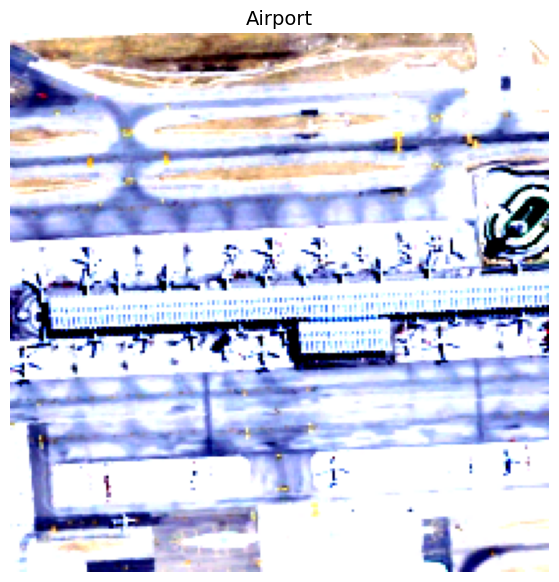

In [ ]:
img_permute = img.permute(1,2,0)

# Print out different shape
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

### 4.1 Turn loaded images into `DataLoader`'s

In [ ]:
batch_size = 32
num_workers = 3

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False, num_workers=num_workers)

train_dataloader, test_dataloader

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


(<torch.utils.data.dataloader.DataLoader at 0x7e4fbe3c6290>,
 <torch.utils.data.dataloader.DataLoader at 0x7e4fbe3c62c0>)

In [ ]:
len(train_dataloader), len(test_dataloader)

(282, 1000)

In [ ]:
# custom_image_path = image_path / '/content/data/supervised/dataset/train/Airport/airport_1.jpg'

# custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape}")
print(f"Label shape: {label.shape}")


Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])


In [ ]:
image_path_list = list(image_path.glob("*/*/*/*/*.jpg"))
image_path_list[:10]

[PosixPath('/content/data/supervised/dataset/train/RailwayStation/railwaystation_240.jpg'),
 PosixPath('/content/data/supervised/dataset/train/RailwayStation/railwaystation_185.jpg'),
 PosixPath('/content/data/supervised/dataset/train/RailwayStation/railwaystation_140.jpg'),
 PosixPath('/content/data/supervised/dataset/train/RailwayStation/railwaystation_170.jpg'),
 PosixPath('/content/data/supervised/dataset/train/RailwayStation/railwaystation_139.jpg'),
 PosixPath('/content/data/supervised/dataset/train/RailwayStation/railwaystation_183.jpg'),
 PosixPath('/content/data/supervised/dataset/train/RailwayStation/railwaystation_7.jpg'),
 PosixPath('/content/data/supervised/dataset/train/RailwayStation/railwaystation_14.jpg'),
 PosixPath('/content/data/supervised/dataset/train/RailwayStation/railwaystation_22.jpg'),
 PosixPath('/content/data/supervised/dataset/train/RailwayStation/railwaystation_100.jpg')]

## 6. Model:efficientnet_b0 Data Augmentation

In [ ]:
torch.manual_seed(42)
from torchvision import datasets, transforms, models
import torch.optim as optim
import torch.nn as nn
torch.manual_seed(42)
import torch.nn as nn

model = models.efficientnet_b0(pretrained=True)
num_classes = 3
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(model.classifier[1].in_features, num_classes)
)

model = model.to(device)

# Define optimizer, loss, and scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 101MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
# Get a single image batch
img_batch, label_batch = next(iter(train_dataloader))
img_batch.shape, label_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [ ]:
model(img_batch.to(device))

tensor([[-0.0587, -0.3469, -0.3741],
        [ 0.0114,  0.2299,  0.0205],
        [ 0.0433, -0.3892, -0.0491],
        [ 0.3483, -0.0198,  0.1942],
        [ 0.1607, -0.0851,  0.1667],
        [-0.4663,  0.0277,  0.1568],
        [ 0.0193, -0.0742,  0.0755],
        [-0.1376,  0.1497, -0.1211],
        [ 0.2242, -0.0900, -0.5720],
        [-0.0405,  0.0179,  0.1413],
        [ 0.1838,  0.1611,  0.3173],
        [ 0.1400, -0.5424,  0.2977],
        [ 0.3220, -0.1481,  0.0301],
        [ 0.0192, -0.1624, -0.0203],
        [ 0.0815, -0.2405,  0.0983],
        [ 0.0153,  0.5490,  0.3267],
        [ 0.2073, -0.3669, -0.1847],
        [-0.1506, -0.0769,  0.0769],
        [ 0.4440, -0.1619,  0.0617],
        [-0.2460, -0.5291,  0.7772],
        [-0.3182, -0.3503,  0.2704],
        [-0.4663,  0.0739, -0.1479],
        [-0.2783, -0.1177,  0.0381],
        [-0.0139, -0.5678,  0.3536],
        [ 0.2073, -0.0814,  0.0145],
        [-0.0407, -0.1181,  0.0616],
        [-0.0205, -0.0572, -0.1400],
 

In [ ]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 3]                    --
├─Sequential: 1-1                                       [1, 1280, 2, 2]           --
│    └─Conv2dNormActivation: 2-1                        [1, 32, 32, 32]           --
│    │    └─Conv2d: 3-1                                 [1, 32, 32, 32]           864
│    │    └─BatchNorm2d: 3-2                            [1, 32, 32, 32]           64
│    │    └─SiLU: 3-3                                   [1, 32, 32, 32]           --
│    └─Sequential: 2-2                                  [1, 16, 32, 32]           --
│    │    └─MBConv: 3-4                                 [1, 16, 32, 32]           1,448
│    └─Sequential: 2-3                                  [1, 24, 16, 16]           --
│    │    └─MBConv: 3-5                                 [1, 24, 16, 16]           6,004
│    │    └─MBConv: 3-6                              

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X) # output model logits
        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item())/len(test_pred_labels)

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm
import torch

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int = 5):
    """
    Trains and evaluates a PyTorch model for a given number of epochs.

    Args:
        model (torch.nn.Module): The model to be trained and evaluated.
        train_dataloader (torch.utils.data.DataLoader): Dataloader for training data.
        test_dataloader (torch.utils.data.DataLoader): Dataloader for testing/validation data.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        loss_fn (torch.nn.Module): Loss function for computing errors.
        epochs (int): Number of epochs to train the model.

    Returns:
        dict: A dictionary containing training and testing loss and accuracy for each epoch.
    """

    # Results dictionary to store metrics
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # Loop through training and testing for each epoch
    for epoch in tqdm(range(epochs), desc="Epochs"):
        # Perform training step
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer
        )

        # Perform testing/validation step
        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn
        )

        # Log epoch metrics
        print(
            f"Epoch: {epoch + 1}/{epochs} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Train Accuracy: {train_acc:.4f} | "
            f"Test Loss: {test_loss:.4f} | "
            f"Test Accuracy: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(float(train_loss))
        results["train_acc"].append(float(train_acc))
        results["test_loss"].append(float(test_loss))
        results["test_acc"].append(float(test_acc))

    return results


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import torch
train_targets = torch.tensor(train_data.targets) if isinstance(train_data.targets, np.ndarray) else train_data.targets
test_targets = torch.tensor(test_data.targets) if isinstance(test_data.targets, np.ndarray) else test_data.targets

all_labels = torch.cat([train_targets, test_targets], dim=0).cpu().numpy()

label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

train_data.targets = torch.tensor(label_encoder.transform(train_targets.cpu().numpy())).to(device)
test_data.targets = torch.tensor(label_encoder.transform(test_targets.cpu().numpy())).to(device)

print("Transformed unique labels:", label_encoder.classes_)


Transformed unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


In [ ]:
valid_classes = [0, 1, 2]
class_mapping = {old: new for new, old in enumerate(valid_classes)}

# 1. Eğitim ve test veri kümelerindeki etiketleri filtrele
train_data.samples = [
    (img_path, class_mapping[label] if label in valid_classes else label)
    for img_path, label in train_data.samples
    if label in valid_classes
]

test_data.samples = [
    (img_path, class_mapping[label] if label in valid_classes else label)
    for img_path, label in test_data.samples
    if label in valid_classes
]

# 2. Yeni etiketlerinizi kontrol edin
train_labels = [label for _, label in train_data.samples]
test_labels = [label for _, label in test_data.samples]

print("Transformed unique labels in train dataset:", set(train_labels))
print("Transformed unique labels in test dataset:", set(test_labels))



Transformed unique labels in train dataset: {0, 1, 2}
Transformed unique labels in test dataset: {0, 1, 2}


In [ ]:
for X_batch, y_batch in train_dataloader:
    print(f"Model output shape: {model(X_batch.to(device)).shape}")  # (batch_size, num_classes)
    print(f"Labels shape: {y_batch.shape}, Labels range: {y_batch.min()} - {y_batch.max()}")
    break


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Model output shape: torch.Size([32, 3])
Labels shape: torch.Size([32]), Labels range: 0 - 2


In [ ]:
import torch.nn as nn
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 7


model = models.efficientnet_b0(pretrained=True)
num_classes = 3
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(model.classifier[1].in_features, num_classes)
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model
model_results = train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epochs:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1/7 | Train Loss: 0.2640 | Train Accuracy: 0.9303 | Test Loss: 0.1611 | Test Accuracy: 0.9663
Epoch: 2/7 | Train Loss: 0.1522 | Train Accuracy: 0.9315 | Test Loss: 0.1649 | Test Accuracy: 0.9438
Epoch: 3/7 | Train Loss: 0.2388 | Train Accuracy: 0.9026 | Test Loss: 0.1033 | Test Accuracy: 0.9663
Epoch: 4/7 | Train Loss: 0.2299 | Train Accuracy: 0.9315 | Test Loss: 0.0343 | Test Accuracy: 0.9888
Epoch: 5/7 | Train Loss: 0.1461 | Train Accuracy: 0.9387 | Test Loss: 0.0603 | Test Accuracy: 0.9775
Epoch: 6/7 | Train Loss: 0.0994 | Train Accuracy: 0.9663 | Test Loss: 0.0586 | Test Accuracy: 0.9775
Epoch: 7/7 | Train Loss: 0.1360 | Train Accuracy: 0.9327 | Test Loss: 0.1035 | Test Accuracy: 0.9775
Total training time: 293.052 seconds


In [ ]:
model_results

{'train_loss': [0.26396831454565894,
  0.15215593319422063,
  0.23878500180748793,
  0.22990707000001118,
  0.1461189323498939,
  0.09944811176795226,
  0.13600312018444619],
 'train_acc': [0.9302884615384616,
  0.9314903846153846,
  0.9026442307692307,
  0.9314903846153846,
  0.9387019230769231,
  0.9663461538461539,
  0.9326923076923077],
 'test_loss': [0.16113274377033843,
  0.16491925314200354,
  0.10325828110526435,
  0.03426023608828603,
  0.060320690511699256,
  0.058550145205795635,
  0.10349480632896414],
 'test_acc': [0.9662921348314607,
  0.9438202247191011,
  0.9662921348314607,
  0.9887640449438202,
  0.9775280898876404,
  0.9775280898876404,
  0.9775280898876404]}

In [ ]:
from typing import Tuple, Dict, List
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary."""

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

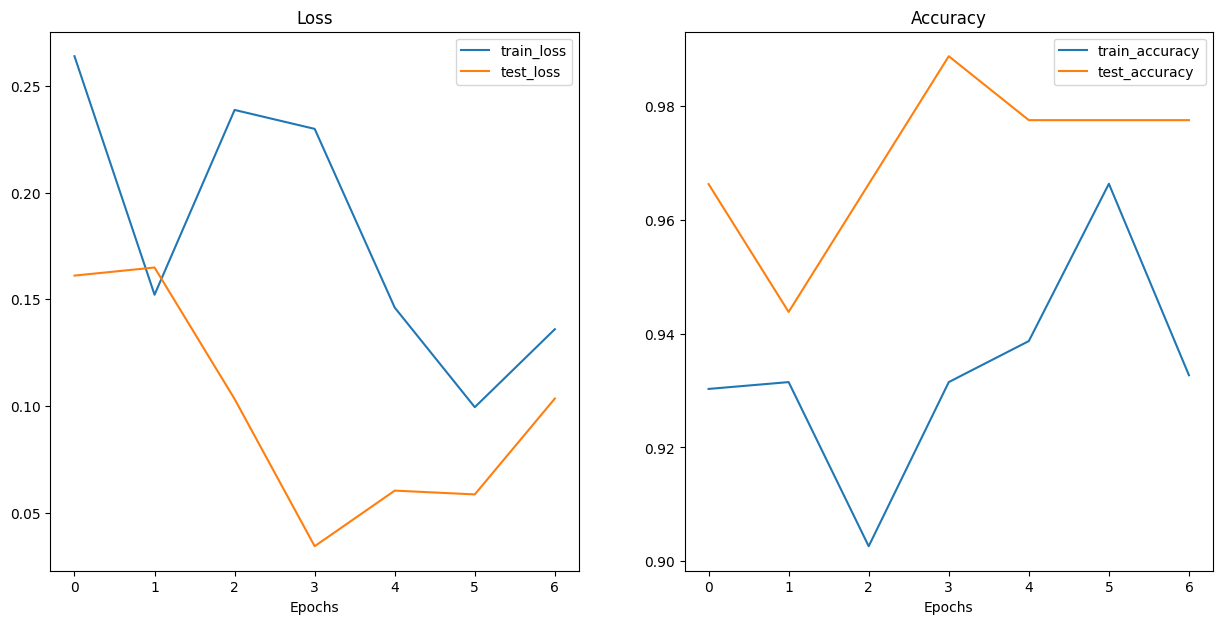

In [ ]:
plot_loss_curves(model_results)

In [ ]:
from sklearn.metrics import accuracy_score
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

test_acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9888


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Accuracy: 97.75%


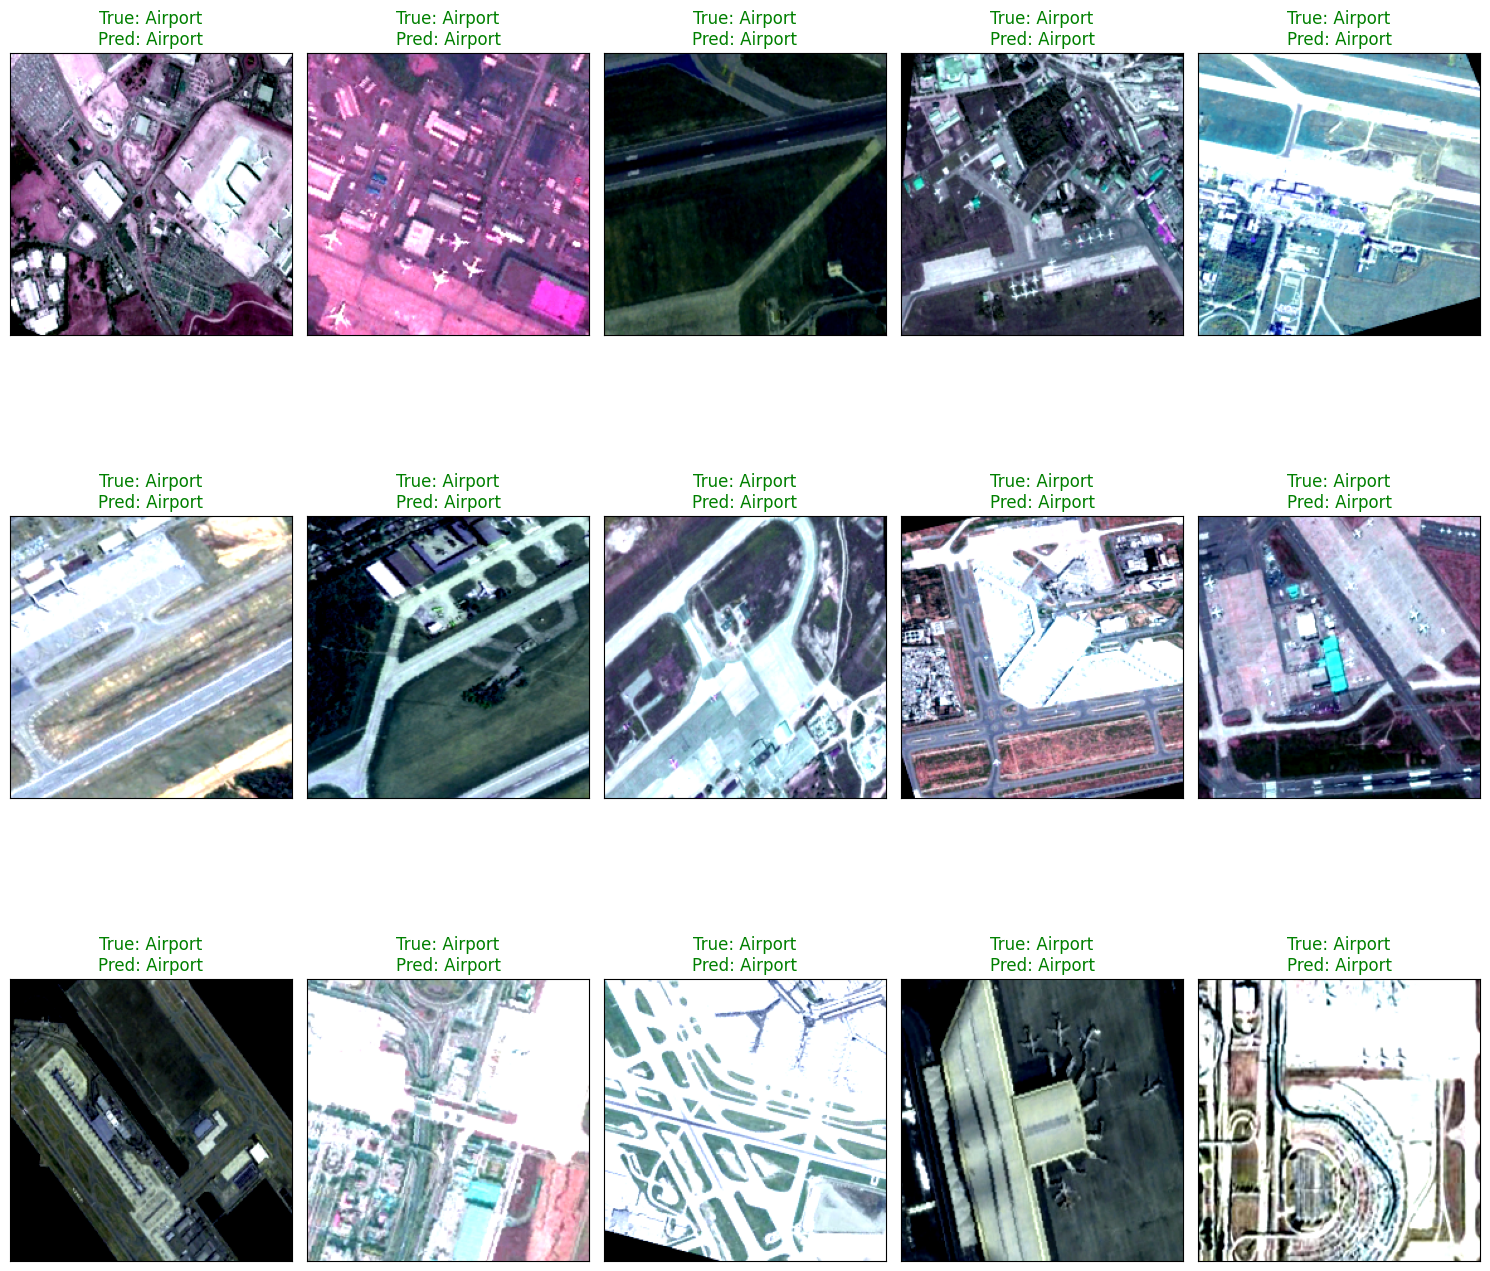

In [ ]:
from torchvision import models

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

class_names = test_dataloader.dataset.classes

model.eval()
correct = 0
total = 0
all_images = []
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_images.extend(images.cpu())
        all_labels.extend(labels.cpu())
        all_predictions.extend(predicted.cpu())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

plt.figure(figsize=(15, 15))

for i in range(min(15, len(all_images))):
    plt.subplot(3, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    image = all_images[i].permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
    image = image * 0.5 + 0.5

    true_label = class_names[all_labels[i].item()]
    pred_label = class_names[all_predictions[i].item()]


    plt.imshow(image)
    plt.title(f"True: {true_label}\nPred: {pred_label}",
              color="green" if true_label == pred_label else "red")

plt.tight_layout()
plt.show()
